In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
%%sql
select
    x
  , y
  , dense_rank() over (order by frame) - 1 as frame
  , frame as og_frame
from frames
where frame in (
    with
        cte as (
            select
                frame
              , count(1) over (partition by frame, x) as num_robots_x
              , count(1) over (partition by frame, y) as num_robots_y
            from frames
        )

    select frame
    from cte
    group by frame
    /* only look at frames with a reasonable density of robots on same line */
    having greatest(max(num_robots_x), max(num_robots_y)) > 15
)

x   y  frame  og_frame
0       67  31      0        31
1       24  39      0        31
2       66  44      0        31
3       35  20      0        31
4       79  51      0        31
...     ..  ..    ...       ...
146495  52  68    292      9973
146496  51  51    292      9973
146497  20  60    292      9973
146498  47  69    292      9973
146499  34  39    292      9973

[146500 rows x 4 columns]

In [4]:
def print_grid(frame):
    df_frame = df_sql[df_sql.frame == frame]
    grid = np.zeros((103, 101), dtype=int)

    for i in range(0, df_frame.shape[0]):
        grid[df_frame.iloc[i].y, df_frame.iloc[i].x] = 1

    return grid

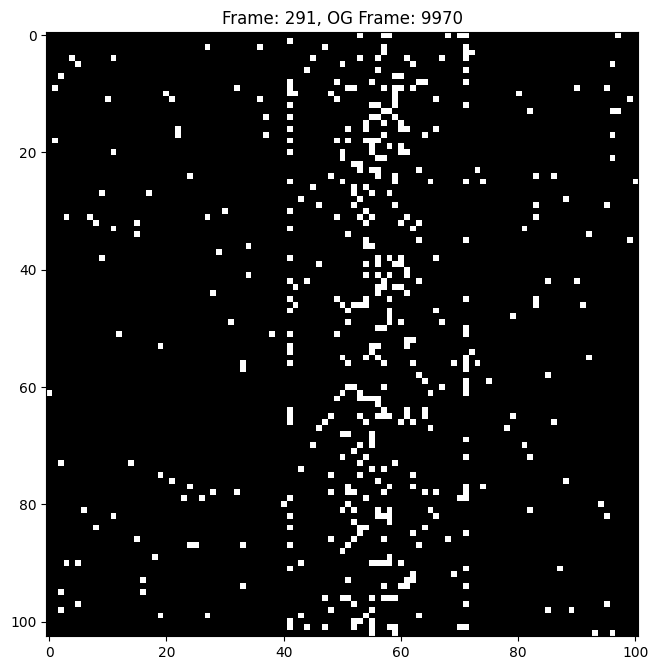

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
# set background color to white
fig.patch.set_facecolor('white')

def animate(i):
    ax.clear()
    ax.imshow(print_grid(i), cmap='gray')
    ax.set_title(f'Frame: {i}, OG Frame: {df_sql[df_sql.frame == i].og_frame.max()}')
    return ax

ani = animation.FuncAnimation(fig, animate, frames=range(0, df_sql.frame.max()), interval=25)
# save to mp4
ani.save('visual.mp4', writer='ffmpeg')
HTML(ani.to_jshtml())